# Kaggle Competition
Olga Bonachera del Pozo

Daniel Kwapien

Alejandro Sánchez

In [1]:
import torch
from torch import nn
from torch import optim
import numpy as np
import time
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [2]:
# Common imports
import os
import numpy as np
import pandas as pd
from termcolor import colored
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
try:
    import opendatasets as od
except ModuleNotFoundError:
    %pip install opendatasets
    import opendatasets as od

In [4]:
od.download("https://www.kaggle.com/competitions/neural-networks-challenge-spring-2024/data")

Skipping, found downloaded files in "./neural-networks-challenge-spring-2024" (use force=True to force download)


In [5]:
train = pd.read_csv('neural-networks-challenge-spring-2024/Train_set.csv')
print(len(train))
train.head()

87554


,ID,T0,T1,T2,T3,T4,T5,T6,T7,T8,...,T178,T179,T180,T181,T182,T183,T184,T185,T186,Class
0,0,0.965812,0.792023,0.116809,0.000000,0.162393,0.213675,0.264957,0.247863,0.270655,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1,1.000000,0.597015,0.000000,0.109453,0.094527,0.084577,0.074627,0.094527,0.114428,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2,0.831382,0.714286,0.491803,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,3,1.000000,0.837705,0.236066,0.037705,0.252459,0.329508,0.319672,0.306557,0.304918,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,4,0.868590,0.448718,0.490385,0.477564,0.461538,0.455128,0.416667,0.304487,0.182692,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


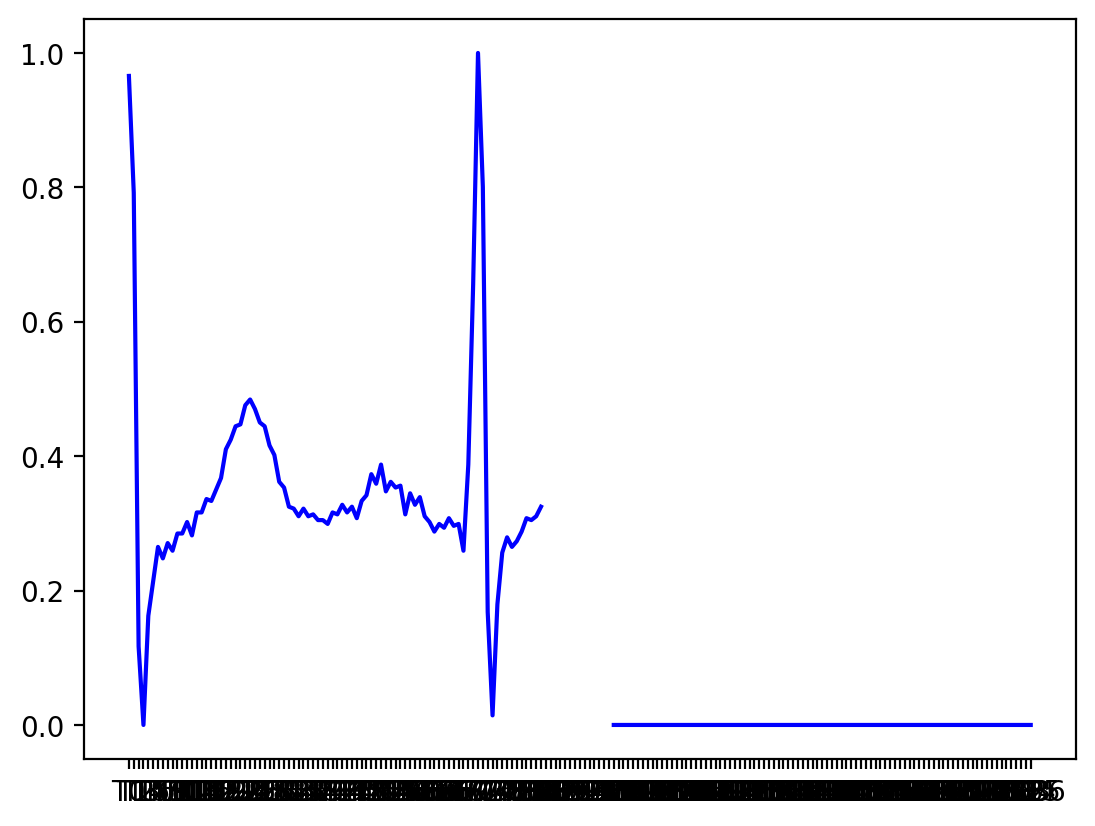

In [6]:
plt.plot(train.loc[0][1:-1], color='blue')

In [7]:
train.isna().sum()

ID          0
T0        474
T1        919
T2       1327
T3       1711
         ... 
T183     4898
T184     4956
T185     4928
T186     4909
Class       0
Length: 189, dtype: int64

All the samples have NA's so we have to find a way of managing them, we can interpolate using the pandas function

In [8]:
train.dtypes

ID         int64
T0       float64
T1       float64
T2       float64
T3       float64
          ...   
T183     float64
T184     float64
T185     float64
T186     float64
Class      int64
Length: 189, dtype: object

In [9]:
#train.columns = pd.to_numeric(train.iloc[:,1:-1].columns)

In [10]:
train_linear = pd.concat([train.iloc[:, 0], train.iloc[:, 1:-1].interpolate(method='linear', limit_direction='both', axis=1), train.iloc[:, -1]], axis=1)
train_spline = pd.concat([train.iloc[:, 0], pd.DataFrame(train.iloc[:, 1:-1].values).interpolate(method='spline', order=3,limit_direction='both', axis=1), train.iloc[:, -1]], axis=1)

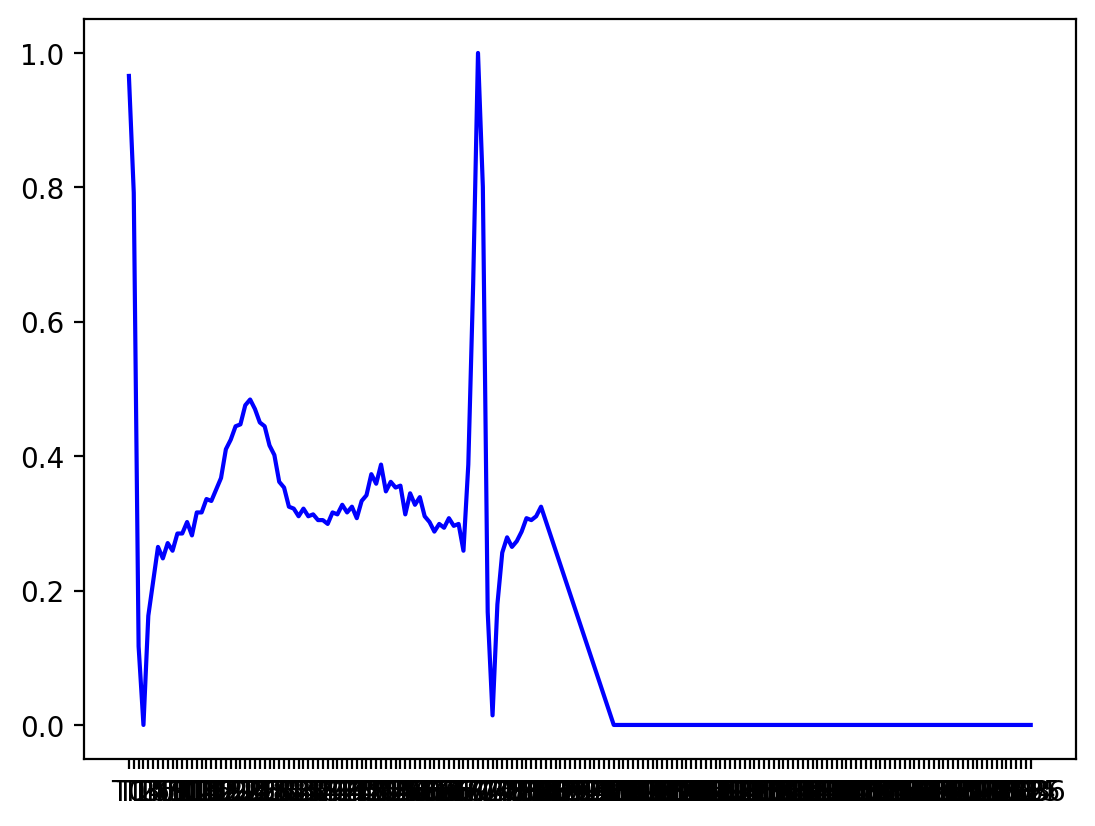

In [11]:
plt.plot(train_linear.loc[0][1:-1], color='blue')

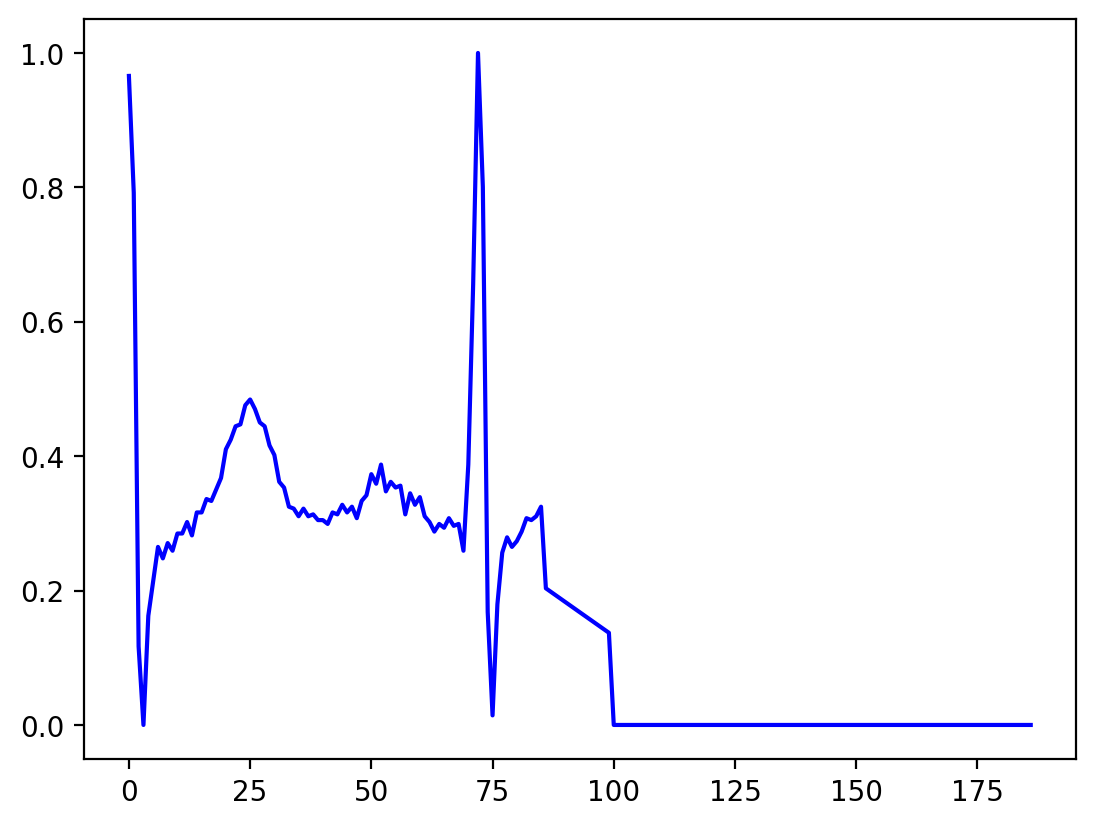

In [12]:
plt.plot(train_spline.loc[0][1:-1], color='blue')

In [13]:
train = train_spline

Definitely spline seems to give way better results

In [14]:
train['Class'].value_counts()

Class
0    72471
4     6431
2     5788
1     2223
3      641
Name: count, dtype: int64

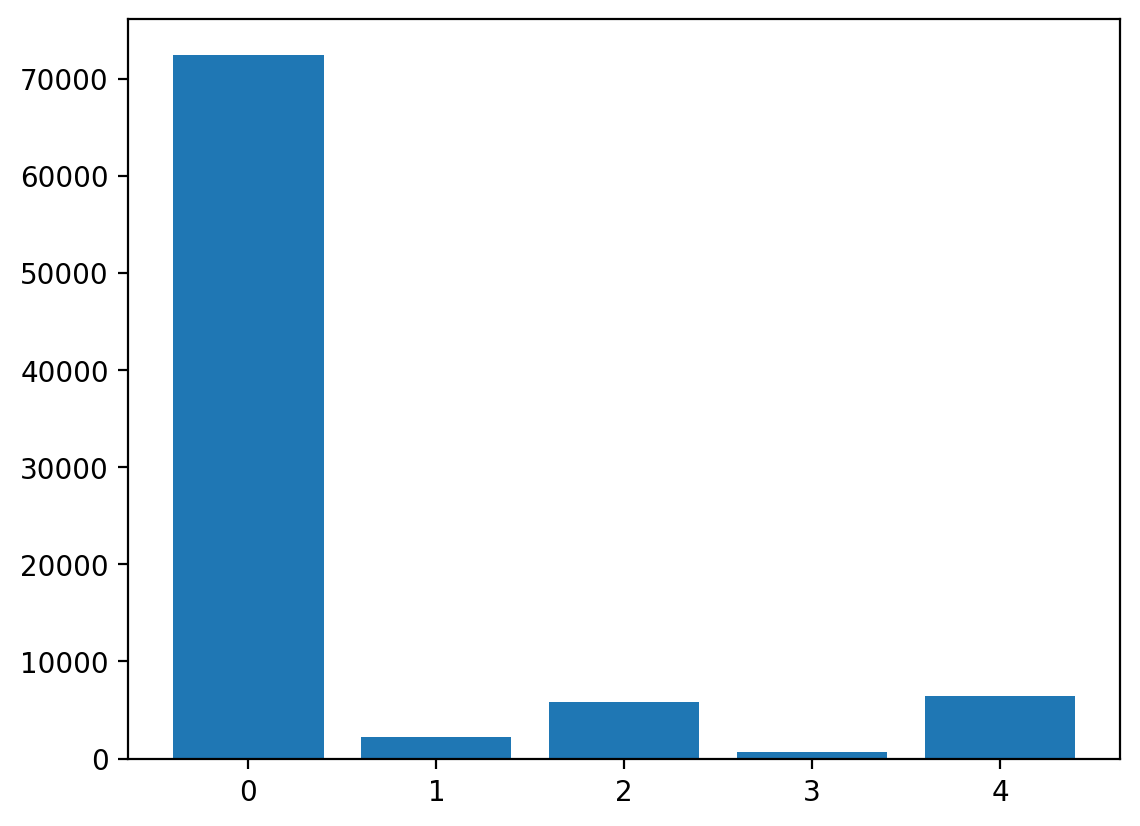

In [15]:
plt.bar(train['Class'].value_counts().index, train['Class'].value_counts().values)
plt.savefig('value_counts.png')

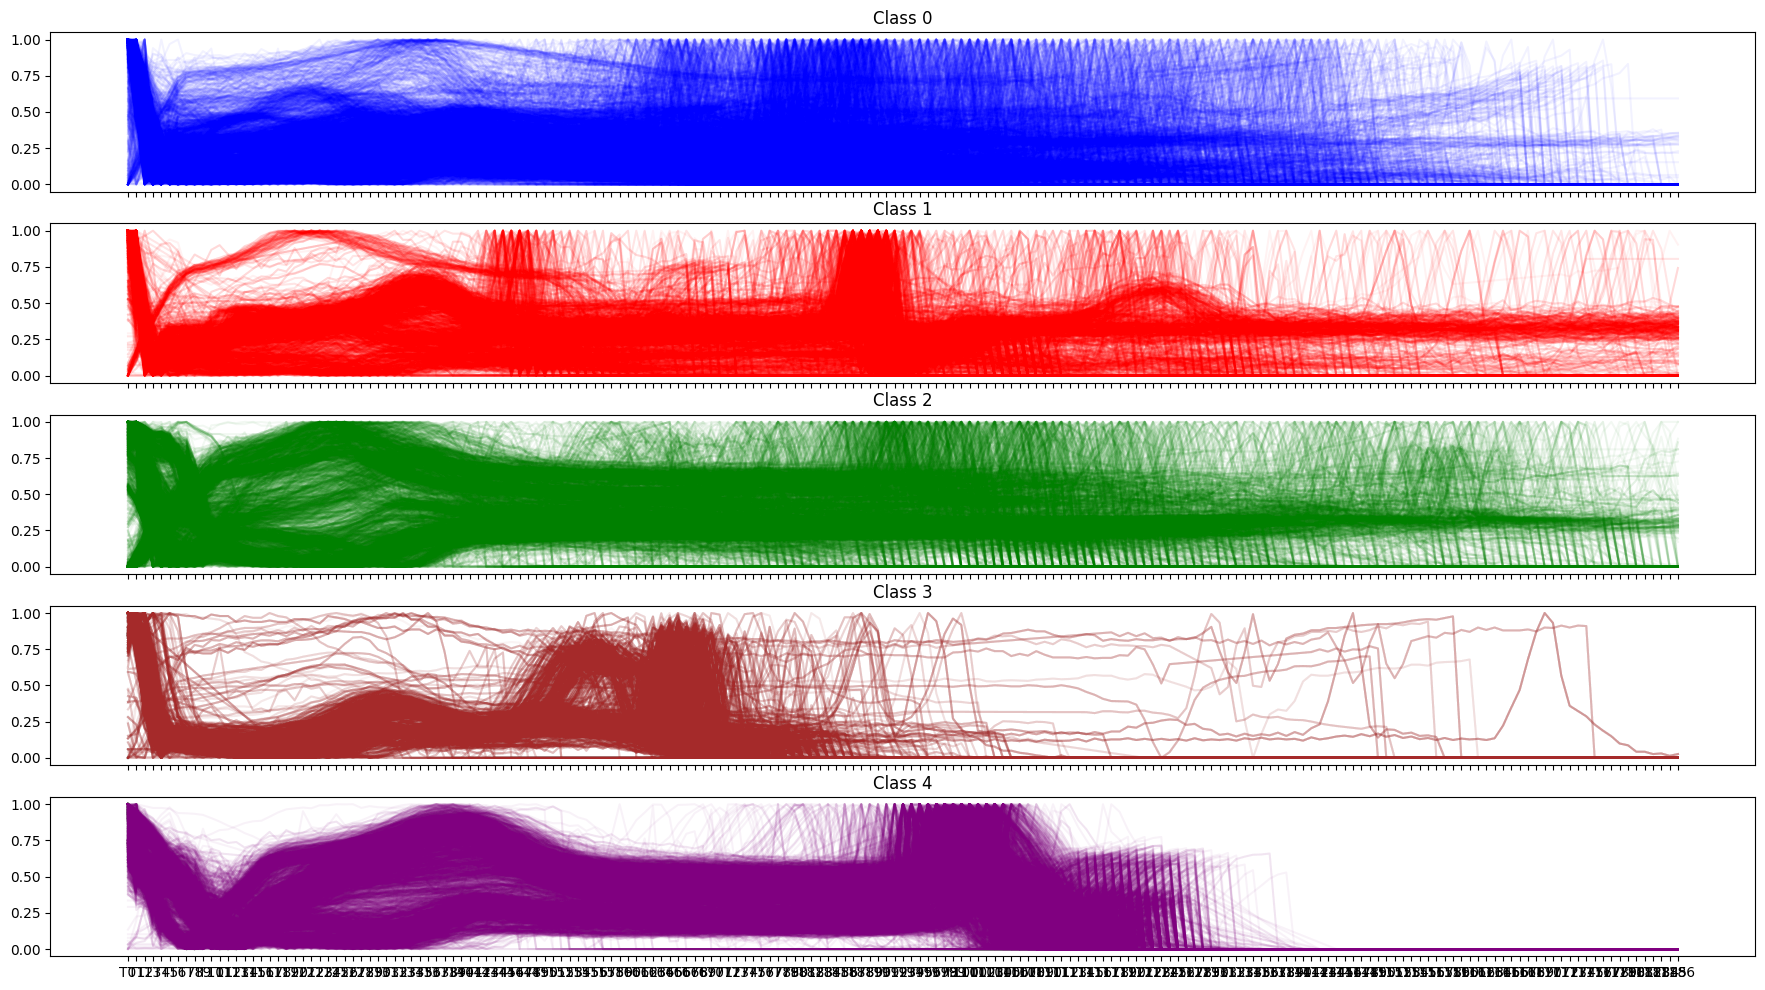

In [ ]:
grouped_data = train_balanced.groupby('Class')
num_classes = len(train['Class'].unique())
colors = ['blue', 'red', 'green', 'brown', 'purple']
fig, axes = plt.subplots(num_classes, 1, sharex=True, figsize=(22, 12))
for i, (cls, group) in enumerate(grouped_data):
    for row in group.iterrows():
      axes[i].plot(row[1][1:-1], color=colors[i], alpha=0.05)

    axes[i].set_title(f'Class {cls}')

In [15]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        ids = self.data.iloc[index, 0]
        series = self.data.iloc[index, 1:-1].values.astype('float32')
        target = self.data.iloc[index, -1]
        return torch.tensor(ids), torch.tensor(series), torch.tensor(target)

trainset = MyDataset(train.iloc[:65000, :])
validset = MyDataset(train.iloc[65000:75000, :])
testset = MyDataset(train.iloc[75000:, :])

In [16]:
class_counts = trainset.data['Class'].value_counts().sort_index()
total_count = class_counts.sum()
weights = class_counts.max() / class_counts
weights = np.array(weights.astype('float32'))
weights

array([  1.      ,  33.468323,  12.669645, 113.67932 ,  11.275162],
      dtype=float32)

In [17]:
from torch.utils.data import WeightedRandomSampler

targets = trainset.data.iloc[:, -1]
class_counts = np.unique(targets, return_counts=True)[1]

weights = class_counts.max() / class_counts
sample_weights = np.array([weights[target] for target in targets]).astype('float32')

sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

In [18]:
from torch.utils.data import BatchSampler
batch_size = 256
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=sampler)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

In [19]:
class ConvNet(nn.Module):

    def __init__(self,output_size,prob=0.3):

        super().__init__()

        kernel_size_1 = 5

        kernel_size_2 = 5

        kernel_size_pool = 4

        out_channels_1 = 6

        out_channels_2 = 16

        out_channels_3 = 36
        
        output_dim_l1 = ((((187-2*0 - kernel_size_1)// 1 + 1) - kernel_size_pool)//kernel_size_pool + 1)

        self.conv1 = nn.Conv1d(in_channels=1, out_channels=out_channels_1, kernel_size=5, stride=1, padding=0, dilation=1)

        self.conv2 = nn.Conv1d(in_channels=out_channels_1, out_channels=out_channels_2, kernel_size=5, stride=1, padding=0, dilation=1)

        # self.conv3 = nn.Conv1d(in_channels=out_channels_2, out_channels=out_channels_3, kernel_size=5, stride=1, padding=0, dilation=1)

        self.pool = nn.MaxPool1d(kernel_size=4)

        self.bn1 = nn.BatchNorm1d(out_channels_1)

        self.bn2 = nn.BatchNorm1d(out_channels_2)

        # self.bn3 = nn.BatchNorm1d(out_channels_3)

        self.linear1 = nn.Linear(704,128)

        self.linear2 = nn.Linear(128,output_size)

        # self.linear3 = nn.Linear(64,output_size)

        #self.linear4 = nn.Linear(64,output_size)

        self.dropout = nn.Dropout(p=prob)

        self.relu = nn.ReLU()

        self.logsoftmax = nn.LogSoftmax(dim=1)


    def forward(self, x):
        # Pass the input tensor through the CNN operations
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # x = self.pool(x)
        # x = self.dropout(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout(x)

        # x = self.conv3(x)
        # x = self.bn3(x)
        # x = self.relu(x)
        # x = self.pool(x)
        # x = self.dropout(x)

        x = x.view(x.size(0), -1)

        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.linear2(x)
        # x = self.relu(x)
        # x = self.dropout(x)

        # x = self.linear3(x)
        # x = self.relu(x)
        # x = self.dropout(x)

        # x = self.linear4(x)
        x = self.logsoftmax(x)
        return x

In [20]:
import torch
import torch.nn as nn

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=1.0, reduction="mean", weight=[1,1,1,1,1]):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        self.weight = weight

    def forward(self, inputs, targets):
        nll_loss = nn.NLLLoss(weight=self.weight, reduction="none")(inputs, targets)
        pt = torch.exp(-nll_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * nll_loss

        if self.reduction == "mean":
            return torch.mean(focal_loss)
        elif self.reduction == "sum":
            return torch.sum(focal_loss)
        else:
            return focal_loss


In [21]:
class CNN_extended(ConvNet):


    def __init__(self, epochs, output_size,prob=0.3, batch_size=64,lr=0.001, lambda_value=0.001, gamma=2.0, alpha=1.0, weights=[1,1,1,1,1], saved_files='./saved_models/1dCNN/CNN_kaggle'):

        super().__init__(output_size,prob)

        self.batch_size = batch_size

        self.lr = lr

        self.optim = optim.Adam(self.parameters(), self.lr, weight_decay=lambda_value)

        self.epochs = epochs

        self.saved_files = saved_files

        self.criterion = FocalLoss(gamma=gamma, alpha=alpha, weight=torch.tensor(weights, dtype=torch.float32))
        self.criterion_valid = nn.NLLLoss(weight=torch.tensor(weights, dtype=torch.float32))

        self.loss_during_training = []

        self.valid_loss_during_training = []
        
        self.loss_during_training_focal = []

        self.valid_loss_during_training_focal = []

        if torch.cuda.is_available():
            self.device = 'cuda'
        else:
            self.device = 'cpu'

        self.to(self.device)


    def trainloop(self,trainloader,validloader):

        self.train()

        for e in range(int(self.epochs)):

            running_loss_focal = 0.
            running_loss= 0.

            for ids, series, labels in trainloader:

                self.optim.zero_grad()

                series = series.reshape(-1, 1, series.shape[1]).to(self.device)

                out = self.forward(series)

                loss = self.criterion(out, labels)

                loss.backward()

                self.optim.step()

                running_loss_focal += loss.item()
                    
                running_loss += self.criterion_valid(out, labels).item()

            self.loss_during_training_focal.append(running_loss_focal/len(trainloader))
            self.loss_during_training.append(running_loss/len(trainloader))

            torch.save(self.state_dict(), self.saved_files+'_epoch_'+str(e)+'.pth')

            with torch.no_grad():

                self.eval()

                running_loss_focal = 0.
                running_loss= 0.

                for ids, series, labels in validloader:

                    seq_length = series.shape[1]

                    series = series.reshape(-1, 1, seq_length)

                    out = self.forward(series)

                    loss = self.criterion(out, labels)

                    running_loss_focal += loss.item()
                    
                    running_loss += self.criterion_valid(out, labels).item()

                self.valid_loss_during_training_focal.append(running_loss_focal/len(validloader))
                self.valid_loss_during_training.append(running_loss/len(validloader))


            if(e % 1 == 0):
                print(f"Training loss after {e} epochs: {self.loss_during_training[-1]}, {self.loss_during_training_focal[-1]}. Validation loss: {self.valid_loss_during_training[-1]}, {self.valid_loss_during_training_focal[-1]}")

In [ ]:
my_cnn = CNN_extended(epochs=30,output_size=5,prob=0.8,batch_size=batch_size,lr=0.001, lambda_value=0.0005, gamma=2.5)
my_cnn.trainloop(trainloader, validloader)
plt.plot(my_cnn.loss_during_training,label='Training Loss')
plt.plot(my_cnn.valid_loss_during_training,label='Validation Loss')
plt.legend()

Training loss after 0 epochs: 1.1561059548160222, 0.5600285034949385. Validation loss: 1.0444907769560814, 0.3852331809699535
Training loss after 1 epochs: 0.5648162942233048, 0.17040122901712815. Validation loss: 0.5922623157501221, 0.15385670866817236
Training loss after 2 epochs: 0.37640556235482375, 0.08579145870574816. Validation loss: 0.47151214703917504, 0.11189095517620444
Training loss after 3 epochs: 0.29138433246865986, 0.0543914109791123. Validation loss: 0.3925732344388962, 0.0832706612534821
Training loss after 4 epochs: 0.24310285961768757, 0.039503442981522384. Validation loss: 0.4206883393228054, 0.10347088649868966
Training loss after 5 epochs: 0.2094533102014872, 0.030820423022176573. Validation loss: 0.29238503240048885, 0.06506220740266144
Training loss after 6 epochs: 0.18682027713754984, 0.025626409025202822. Validation loss: 0.348628057539463, 0.09584645172581077
Training loss after 7 epochs: 0.16305055173011276, 0.02017604162564545. Validation loss: 0.238027215

In [ ]:
# Recovering the best validation parameters
idx_min = np.argsort(my_cnn.valid_loss_during_training)
my_cnn.load_state_dict(torch.load(my_cnn.saved_files+'_epoch_'+str(idx_min[0])+'.pth'))

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

def accuracy(dataloader,model, label=None):

    all_predictions = []
    all_labels = []
    
    with torch.no_grad():

        accuracy = 0.

        for ids, series,labels in dataloader:

            logprobs = model.forward(series.reshape(-1,1,187)).detach().numpy()

            prediction = np.argmax(logprobs,1)
            all_predictions.extend(prediction)
            all_labels.extend(labels.numpy())

            if label is None or prediction==label:
                accuracy += accuracy_score(labels.numpy(),prediction,normalize=True)
        
        cm = confusion_matrix(all_labels, all_predictions, normalize='pred')

        return accuracy/len(dataloader), cm

In [33]:
acc, cm = accuracy(trainloader,my_cnn)
print(f"Train accuracy {acc}")
acc, cm = accuracy(validloader,my_cnn)
print(f"Validation accuracy {acc}")
acc, cm = accuracy(testloader,my_cnn)
print(f"Test accuracy {acc}")

Train accuracy 0.19982118008417052
Validation accuracy 0.82265625
Test accuracy 0.825015625


In [ ]:
# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# !pip install torcheval

In [ ]:
from torcheval.metrics.functional import multiclass_f1_score
def f1_score(dataloader, model):

    score = 0.

    with torch.no_grad():

        for ids, series, labels in dataloader:
            logprobs = model.forward(series.reshape(-1,1, 187))
            probs = torch.nn.functional.softmax(logprobs, dim=1)
            predictions = []
            for probs_single in probs:
                    predictions.append(probs_single.argmax().item())

            #prediction = np.argmax(logprobs,1)
            score += multiclass_f1_score(torch.tensor(predictions), labels, num_classes=5, average='macro')

        score = score/len(dataloader)
        return score

In [ ]:
print(f"Train F1-score {f1_score(trainloader, my_cnn)}")
print(f"Validation F1-score {f1_score(validloader, my_cnn)}")
print(f"Test F1-score {f1_score(testloader, my_cnn)}")

In [266]:
test = pd.read_csv('neural-networks-challenge-spring-2024/Test_set.csv')
test = pd.concat([train.iloc[:, 0], pd.DataFrame(test.iloc[:, 1:-1].values).interpolate(method='spline', order=5,limit_direction='both', axis=1), train.iloc[:, -1]], axis=1)

In [267]:
class MySubmissionDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        id = self.data.iloc[index, 0]
        series = self.data.iloc[index, 1:].values.astype('float32')
        return torch.tensor(id), torch.tensor(series)

In [268]:
submissionset =  MySubmissionDataset(test)
submissionloader = torch.utils.data.DataLoader(submissionset, batch_size=1, shuffle=False)

In [269]:
def create_submission(dataloader, model):

    model.eval()

    ids = []
    predictions = []

    with torch.no_grad():
        for id, series in dataloader:
            logprobs = model.forward(series.reshape(-1,1, 187)).detach().numpy()
            prediction = np.argmax(logprobs,1)
            ids.append(id.item())
            predictions.append(prediction[0])

    df = pd.DataFrame({'ID': ids, 'Pred_Class': predictions})

    return df

In [270]:
submission = create_submission(submissionloader, my_cnn)
submission.set_index("ID", inplace=True)

In [271]:
submission

,Pred_Class
ID,
0,0
1,0
2,0
3,2
4,0
...,...
21887,0
21888,4
21889,0


In [272]:
submission.to_csv('submission_89f1_2105.csv')

In [368]:
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

competition = "neural-networks-challenge-spring-2024"
submission_file = "submission_89f1_2105.csv"
message = "my latest submission"

api.competition_submit(submission_file, message, competition)


100%|██████████| 160k/160k [00:00<00:00, 198kB/s]  


Successfully submitted to Neural networks challenge spring 2024

Tests:

* Model 1
  * **Parameters**:
    * Weighted Sampler
    * 1DCONV 1->10->30->(Maxpool-2)-> FC
    * Epochs: 30
    * Dropout: 0.8
    * Batch_size: 256
    *
  * **Results**
    * Time:35 min
    * Tr Loss: 0.02158779981839434
    * Va Loss: 0.11951268585107755
    * Tr Accur: 0.9949694966739071
    * Va Accur: 0.9763671875
    * Te Accur: 0.974453125
    * F1 Valid: 0.8766461610794067
    * F1 Test: 0.8571584820747375
    * F1 Kaggle: 0.88026
    
* Model 2
  * **Parameters**:
    * Weighted Sampler
    * 1DCONV 1->6->16 (maxpool-2) -> 30 (pool-2)-> FC (4 layers)
    * Epochs: 30
    * Dropout: 0.8
    * Batch_size: 256
    * Weight decay: 0.001
    * Batch normalization
  * **Results**
    * Time: 35 min
    * Tr Loss: 0.02158779981839434
    * Va Loss: 0.0951268585107755
    * Tr Accur: 0.9931956302137644
    * Va Accur: 0.9755859375
    * Te Accur: 0.9777584443196405
    * F1 Valid: 0.8834397196769714
    * F1 Test: 0.8866188526153564
    * F1 Kaggle: 0.89068
    
* Model 3
  * **Parameters**:
    * Weighted Sampler
    * 1DCONV 1->6->16 (maxpool-2) -> 30 (pool-2)-> FC (4 layers)
    * Batch normalization
    * Epochs: 30
    * Dropout: 0.8
    * Batch_size: 256
    * Weight decay: 0
    * Focal Loss: gamma=2.5
  * **Results**
    * Time: 35 min
    * Tr Loss: 0.02158779981839434
    * Va Loss: 0.0791268585107755
    * Tr Accur: 0.9931956302137644
    * Va Accur: 0.9755859375
    * Te Accur: 0.9777584443196405
    * F1 Valid: 0.8834397196769714
    * F1 Test: 0.8866188526153564
    * F1 Kaggle: 0.89181